In [19]:
!pip install librosa==0.10.1
!pip install numpy --upgrade --force-reinstall
!pip install -U scikit-learn
!pip install librosa
!pip install matplotlib
!pip install tensorflow

  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
  Using cached numpy-2.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached numpy-2.0.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (19.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.5
    Uninstalling numpy-

**CNN**

In [25]:
# 📌 MONTAGE & IMPORTS
from google.colab import drive
drive.mount('/content/drive')

import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import resample, class_weight
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from collections import Counter
from imblearn.over_sampling import RandomOverSampler

# 📂 PARAMÈTRES
DATA_PATH = "/content/drive/MyDrive"
SAMPLE_RATE = 22050
DURATION = 3
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

# 🎵 EXTRACTION MEL
def extract_features(file_path, max_len=SAMPLES_PER_TRACK):
    try:
        y, sr = librosa.load(file_path, sr=SAMPLE_RATE, duration=DURATION)
        if len(y) < max_len:
            y = np.pad(y, (0, max_len - len(y)))
        else:
            y = y[:max_len]
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        mel_db = librosa.power_to_db(mel, ref=np.max)
        return mel_db if not np.isnan(mel_db).any() else None
    except:
        return None

# 📅 CHARGEMENT DATA
def load_data():
    X, y = [], []
    label_map = {'non_belle_voix': 0, 'belle_voix': 1}
    for label_name, label in label_map.items():
        folder = os.path.join(DATA_PATH, label_name)
        for fname in os.listdir(folder):
            if fname.endswith(".wav"):
                fpath = os.path.join(folder, fname)
                feat = extract_features(fpath)
                if feat is not None:
                    X.append(feat)
                    y.append(label)
    return np.array(X), np.array(y)

# ⚖️ ÉQUILIBRAGE AVEC OVERSAMPLING
def balance(X, y):
    X_flat = X.reshape((X.shape[0], -1))
    ros = RandomOverSampler(random_state=42)
    X_res, y_res = ros.fit_resample(X_flat, y)
    X_res = X_res.reshape((-1, X.shape[1], X.shape[2]))
    return X_res, y_res

# 🧼 PRÉTRAITEMENT
def preprocess(X, y):
    X = np.array([(x - x.min()) / (x.max() - x.min() + 1e-8) for x in X])
    X = X[..., np.newaxis]  # (N, H, W, 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    return X_train, X_test, y_train, y_test, dict(enumerate(class_weights))

# 🧐 CNN AMÉLIORÉ

def build_cnn(input_shape):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(64, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.Conv2D(128, (3,3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),

        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 🚀 PIPELINE
X, y = load_data()
print(f"🔎 Avant équilibrage : {Counter(y)}")
X, y = balance(X, y)
print(f"✅ Après équilibrage : {Counter(y)}")
X_train, X_test, y_train, y_test, class_weights = preprocess(X, y)
print(f"📀 Shape train: {X_train.shape}, test: {X_test.shape}")

# 🎯 ENTRAÎnEMENT
model = build_cnn(X_train.shape[1:])
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=30,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop, lr_scheduler],
    shuffle=True
)

# 📊 ÉVALUATION
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"🎯 Test accuracy : {test_acc:.4f}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Exception ignored on calling ctypes callback function: <function ThreadpoolController._find_libraries_with_dl_iterate_phdr.<locals>.match_library_callback at 0x7b2eafde1ee0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1005, in match_library_callback
    self._make_controller_from_path(filepath)
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 1187, in _make_controller_from_path
    lib_controller = controller_class(
                     ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/threadpoolctl.py", line 114, in __init__
    self.dynlib = ctypes.CDLL(filepath, mode=_RTLD_NOLOAD)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/ctypes/__init__.py", line 376, in __init__
    self._handle = _dlopen(self._name, mode)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^
OSError: dlopen() error


🔎 Avant équilibrage : Counter({np.int64(0): 7005, np.int64(1): 3612})
✅ Après équilibrage : Counter({np.int64(0): 7005, np.int64(1): 7005})
📀 Shape train: (11208, 128, 130, 1), test: (2802, 128, 130, 1)
Epoch 1/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 508s 2s/step - accuracy: 0.6871 - loss: 0.5807 - val_accuracy: 0.6227 - val_loss: 0.6301 - learning_rate: 0.0010
Epoch 2/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 478s 2s/step - accuracy: 0.7235 - loss: 0.5237 - val_accuracy: 0.5308 - val_loss: 0.9829 - learning_rate: 0.0010
Epoch 3/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7421 - loss: 0.5015
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
281/281 ━━━━━━━━━━━━━━━━━━━━ 477s 2s/step - accuracy: 0.7421 - loss: 0.5015 - val_accuracy: 0.5709 - val_loss: 1.2685 - learning_rate: 0.0010
Epoch 4/30
281/281 ━━━━━━━━━━━━━━━━━━━━ 482s 2s/step - accuracy: 0.7518 - loss: 0.4883 - val_accuracy: 0.7480 - val_loss: 0.4884 - learning_rate: 5.0000e-04
Epoch 5/30
281/281 ━━━━━━━━━━━━

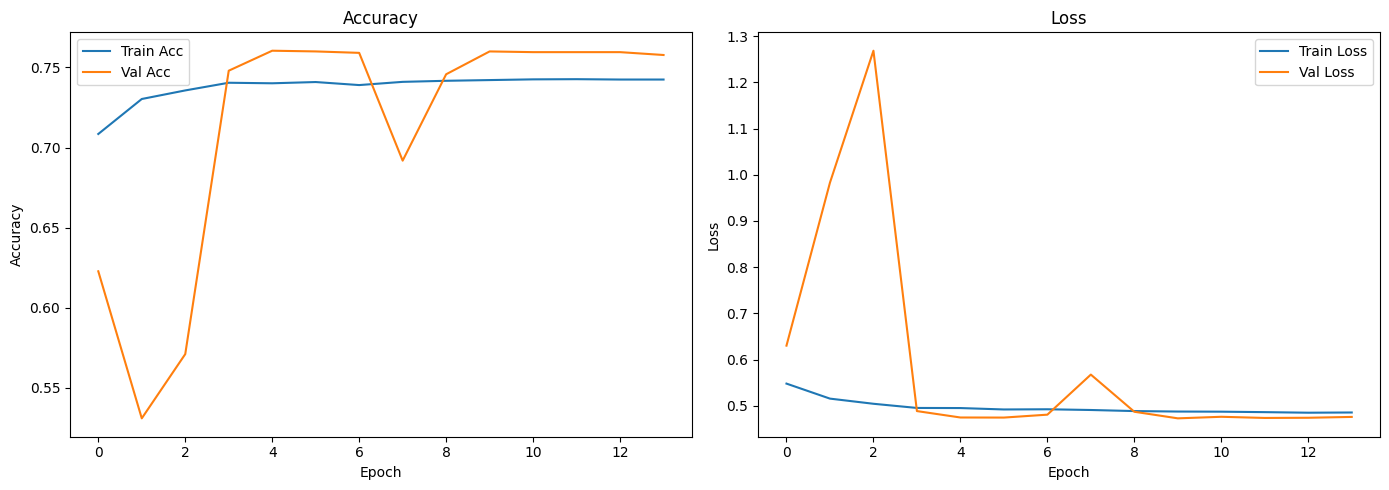

88/88 ━━━━━━━━━━━━━━━━━━━━ 30s 333ms/step


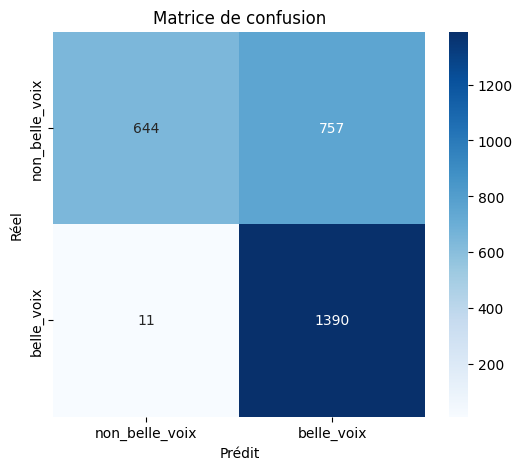

                precision    recall  f1-score   support

non_belle_voix       0.98      0.46      0.63      1401
    belle_voix       0.65      0.99      0.78      1401

      accuracy                           0.73      2802
     macro avg       0.82      0.73      0.70      2802
  weighted avg       0.82      0.73      0.70      2802

✅ Modèle sauvegardé à : /content/drive/MyDrive/cnn_belle_voix_model.h5


In [26]:
# 📊 COURBES D'ENTRAÎNEMENT
def plot_history(history):
    plt.figure(figsize=(14,5))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history)

# 📊 MATRICE DE CONFUSION
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

y_pred = (model.predict(X_test) > 0.5).astype(int).flatten()
cm = confusion_matrix(y_test, y_pred)
labels = ['non_belle_voix', 'belle_voix']

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()

print(classification_report(y_test, y_pred, target_names=labels))

# 💾 SAUVEGARDE DU MODÈLE
model_path = '/content/drive/MyDrive/cnn_belle_voix_model.h5'
model.save(model_path)
print(f"✅ Modèle sauvegardé à : {model_path}")


**LSTM**

✅ Chargé : 10617 fichiers


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 40s 162ms/step - accuracy: 0.6491 - loss: 0.5839 - val_accuracy: 0.6492 - val_loss: 0.4947
Epoch 2/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 40s 159ms/step - accuracy: 0.6631 - loss: 0.4899 - val_accuracy: 0.6498 - val_loss: 0.4813
Epoch 3/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 35s 164ms/step - accuracy: 0.6680 - loss: 0.4909 - val_accuracy: 0.6557 - val_loss: 0.4829
Epoch 4/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 41s 165ms/step - accuracy: 0.6588 - loss: 0.4851 - val_accuracy: 0.6510 - val_loss: 0.4774
Epoch 5/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 41s 166ms/step - accuracy: 0.6613 - loss: 0.4775 - val_accuracy: 0.6416 - val_loss: 0.4799
Epoch 6/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 40s 161ms/step - accuracy: 0.6668 - loss: 0.4813 - val_accuracy: 0.6404 - val_loss: 0.4824
Epoch 7/15
213/213 ━━━━━━━━━━━━━━━━━━━━ 33s 155ms/step - accuracy: 0.6740 - loss: 0.4726 - val_accuracy: 0.6627 - val_loss: 0.4777


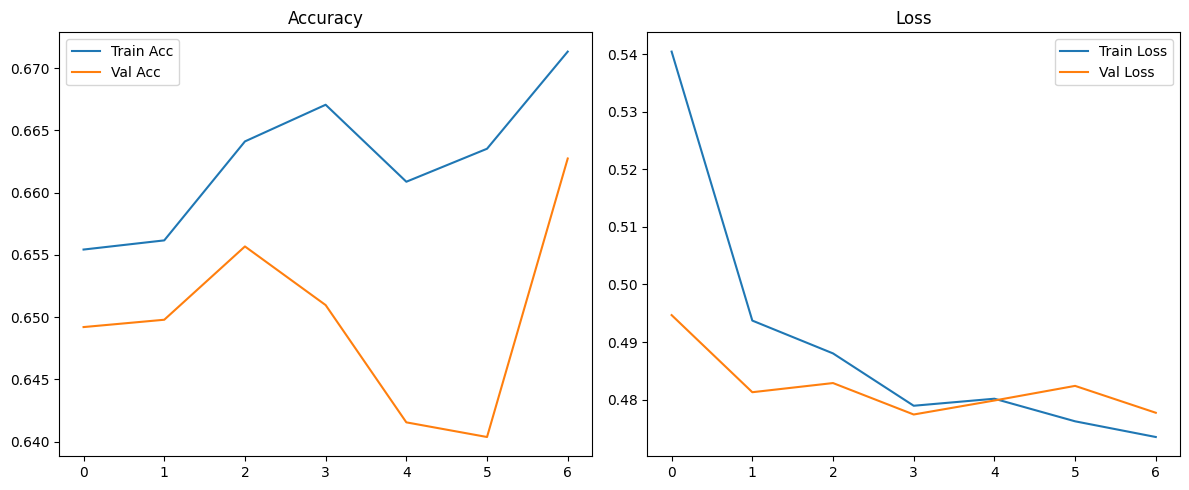

67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step

🧾 Rapport de classification :

              precision    recall  f1-score   support

           0       0.84      0.56      0.67      1401
           1       0.48      0.80      0.60       723

    accuracy                           0.64      2124
   macro avg       0.66      0.68      0.64      2124
weighted avg       0.72      0.64      0.65      2124



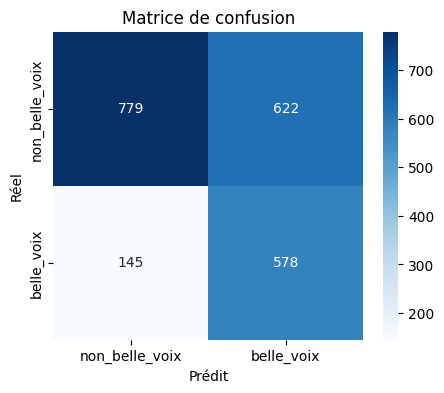

✅ Modèle sauvegardé : /content/drive/MyDrive/lstm_belle_voix_model.h5


In [24]:
# 📦 Imports
import os
import numpy as np
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns

# 🔧 Configuration
SAMPLE_RATE = 22050
DURATION = 3
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION
DATA_PATH = "/content/drive/MyDrive"  # à adapter si besoin

# 🎵 Extraction MFCC
def extract_mfcc(file_path, max_len=SAMPLES_PER_TRACK):
    try:
        audio, sr = librosa.load(file_path, sr=SAMPLE_RATE)
        if len(audio) < max_len:
            audio = np.pad(audio, (0, max_len - len(audio)))
        else:
            audio = audio[:max_len]
        mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
        return mfcc.T
    except Exception as e:
        print(f"❌ Erreur MFCC : {file_path} : {e}")
        return None

# 📂 Chargement des données
def load_mfcc_data():
    X, y = [], []
    labels_map = {"belle_voix": 1, "non_belle_voix": 0}
    for folder_name, label in labels_map.items():
        folder_path = os.path.join(DATA_PATH, folder_name)
        if not os.path.exists(folder_path):
            print(f"⚠️ Dossier introuvable : {folder_path}")
            continue
        for file_name in os.listdir(folder_path):
            if file_name.endswith(".wav"):
                path = os.path.join(folder_path, file_name)
                mfcc_data = extract_mfcc(path)
                if mfcc_data is not None:
                    X.append(mfcc_data)
                    y.append(label)
    return np.array(X, dtype=object), np.array(y)

# ✅ Chargement et padding
X_mfcc, y_mfcc = load_mfcc_data()
print(f"✅ Chargé : {len(X_mfcc)} fichiers")

max_length = max([x.shape[0] for x in X_mfcc])
X_mfcc_padded = pad_sequences(X_mfcc, maxlen=max_length, dtype='float32', padding='post')
X_mfcc_padded = X_mfcc_padded[..., np.newaxis]  # ajout canal

# ✂️ Split
X_train, X_test, y_train, y_test = train_test_split(
    X_mfcc_padded, y_mfcc, test_size=0.2, stratify=y_mfcc, random_state=42
)

# 🧠 Modèle LSTM
def create_lstm_model(input_shape):
    model = models.Sequential([
        layers.Masking(mask_value=0., input_shape=input_shape),
        layers.LSTM(64, return_sequences=True),
        layers.LSTM(32),
        layers.Dense(32, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# 🚀 Entraînement
lstm_model = create_lstm_model((X_train.shape[1], X_train.shape[2]))
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = lstm_model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

# 📈 Courbes
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# 📊 Évaluation
y_pred = (lstm_model.predict(X_test) > 0.5).astype("int32")
print("\n🧾 Rapport de classification :\n")
print(classification_report(y_test, y_pred))

# 🔍 Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["non_belle_voix", "belle_voix"], yticklabels=["non_belle_voix", "belle_voix"])
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion")
plt.show()

# 💾 Sauvegarde
model_path = '/content/drive/MyDrive/lstm_belle_voix_model.h5'
lstm_model.save(model_path)
print(f"✅ Modèle sauvegardé : {model_path}")

# 🔮 Prédiction sur fichier .wav
def predict_voice(file_path):
    mfcc = extract_mfcc(file_path)
    if mfcc is None:
        print("❌ MFCC non valide")
        return
    mfcc_padded = pad_sequences([mfcc], maxlen=max_length, dtype='float32', padding='post')
    mfcc_padded = mfcc_padded[..., np.newaxis]
    proba = lstm_model.predict(mfcc_padded)[0][0]
    classe = "belle_voix" if proba > 0.5 else "non_belle_voix"
    print(f"🔍 Fichier : {os.path.basename(file_path)}")
    print(f"🔊 Classe prédite : {classe} (probabilité : {proba:.2f})")

# Exemple : prediction sur un fichier
# predict_voice("/content/drive/MyDrive/belle_voix/exemple.wav")
